In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import itertools

# DATA WRANGLING

## Gathering Data

In [2]:
# load dataset
file_path = '../data/retail_store_inventory.csv'
dataset = pd.read_csv(file_path)

dataset.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


## Assessing Data

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

insight:
- terlihat tidak ada missing value di dataset
- namun tipe data pada kolom date bukan format datetime dan akan diubah pada cleaning data nanti

In [4]:
# melihat apakah ada missing value
dataset.isnull().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

insight:
- tidak ada missing value dari dataset

In [5]:
# melihat duplikasi data dan ringkasan parameter statistik
print("jumlah duplikasi data: ", dataset.duplicated().sum())
dataset.describe()

jumlah duplikasi data:  0


,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000


insight:
- tidak ada duplikasi data
- ringkasan dari parameter statistik pun terlihat cukup "normal"

## Data Cleaning

In [8]:
# mengubah tipe data pada kolom date menjadi datetime format
dataset['Date'] = pd.to_datetime(dataset['Date'])

# cek kembali info dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                73100 non-null  datetime64[ns]
 1   Store ID            73100 non-null  object        
 2   Product ID          73100 non-null  object        
 3   Category            73100 non-null  object        
 4   Region              73100 non-null  object        
 5   Inventory Level     73100 non-null  int64         
 6   Units Sold          73100 non-null  int64         
 7   Units Ordered       73100 non-null  int64         
 8   Demand Forecast     73100 non-null  float64       
 9   Price               73100 non-null  float64       
 10  Discount            73100 non-null  int64         
 11  Weather Condition   73100 non-null  object        
 12  Holiday/Promotion   73100 non-null  int64         
 13  Competitor Pricing  73100 non-null  float64   

insight:
- dari basic info di atas, dataset sudah clean
- namun saya melihat sepertinya perlu membuat fitur baru dari data yang ada, dengan harapan akan meningkatkan akurasi model prediksi

In [9]:
# membuat fitur baru

# menambahkan kolom DayofWeek untuk menganalisis tren mingguan serta bulan dan tahun untuk menangkap pola musiman dan tahunan
dataset['DayOfWeek'] = dataset['Date'].dt.day_name()
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year

# membuat kolom discounted Price yang mengalikan harga dengan diskon
dataset['Discounted Price'] = dataset['Price'] * (1 - dataset['Discount'] / 100)

# memeriksa apakah promosi aktif
dataset['Promotion Active'] = np.where(dataset['Holiday/Promotion'] == 1, True, False)

# melihat dataset dengan kolom baru
print("dataset dengan feature baru:")
dataset.head()

dataset dengan feature baru:


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality,DayOfWeek,Month,Year,Discounted Price,Promotion Active
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn,Saturday,1,2022,26.800,False
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn,Saturday,1,2022,50.408,False
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer,Saturday,1,2022,25.191,True
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn,Saturday,1,2022,29.448,True
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer,Saturday,1,2022,73.640,False


# EDA

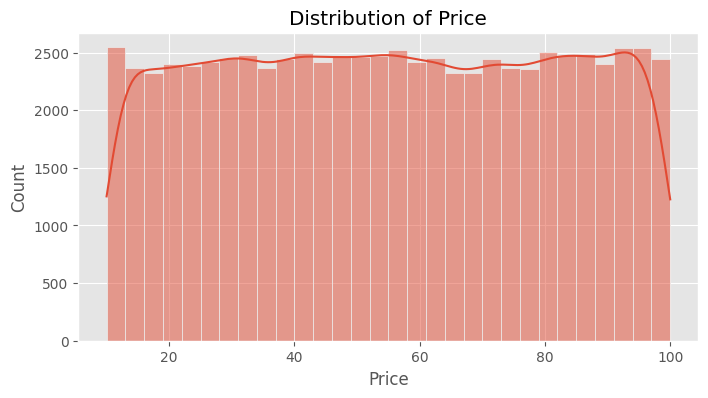

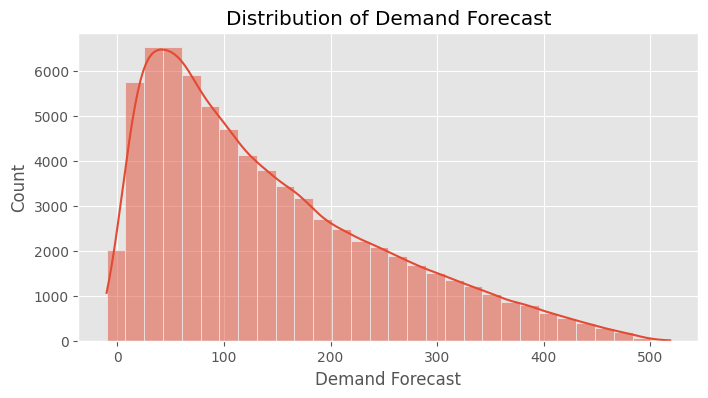

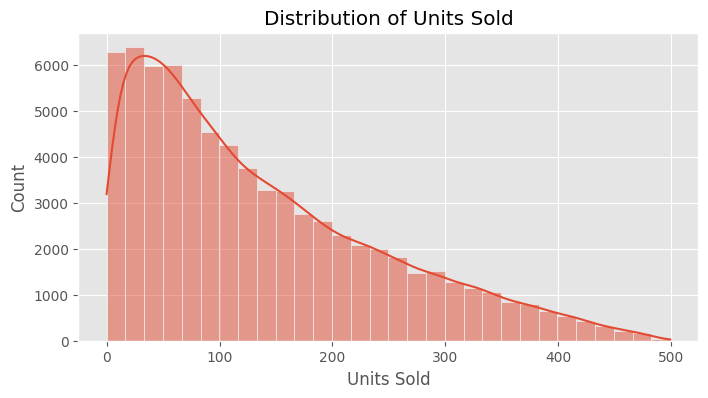

In [10]:
# visualisasi distribusi data pada kolom numerik
plt.style.use('ggplot') # konfigurasi visualisasi

numerical_columns = ['Price', 'Demand Forecast', 'Units Sold']
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(dataset[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

insight:
- `Price`: Distribusi harga menunjukkan pola normal, "mungkin" terdapat beberapa outlier pada harga yang lebih tinggi.
- `Demand Forecast`: Sebagian besar permintaan berada pada kisaran rata-rata yang normal.
- `Units Sold`: Distribusi penjualan memperlihatkan nilai mayoritas berada di kisaran yang sama, dengan beberapa lonjakan untuk produk populer.

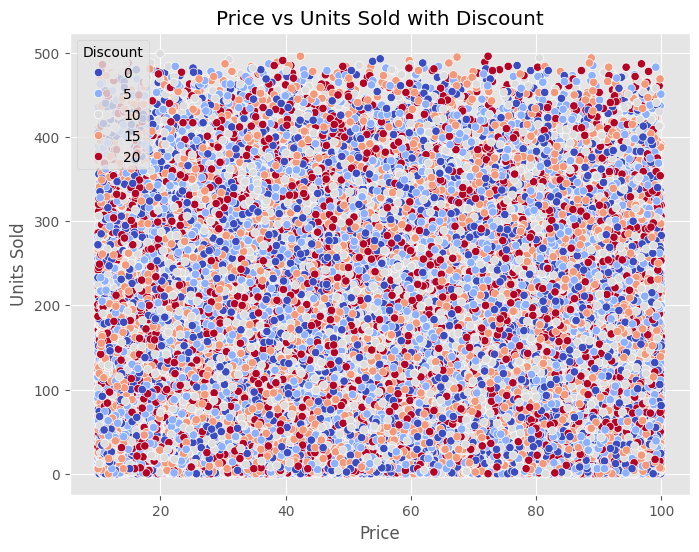

In [11]:
# analisis hubungan antar variabel
plt.figure(figsize=(8, 6))
sns.scatterplot(data=dataset, x='Price', y='Units Sold', hue='Discount', palette='coolwarm')
plt.title('Price vs Units Sold with Discount')
plt.show()

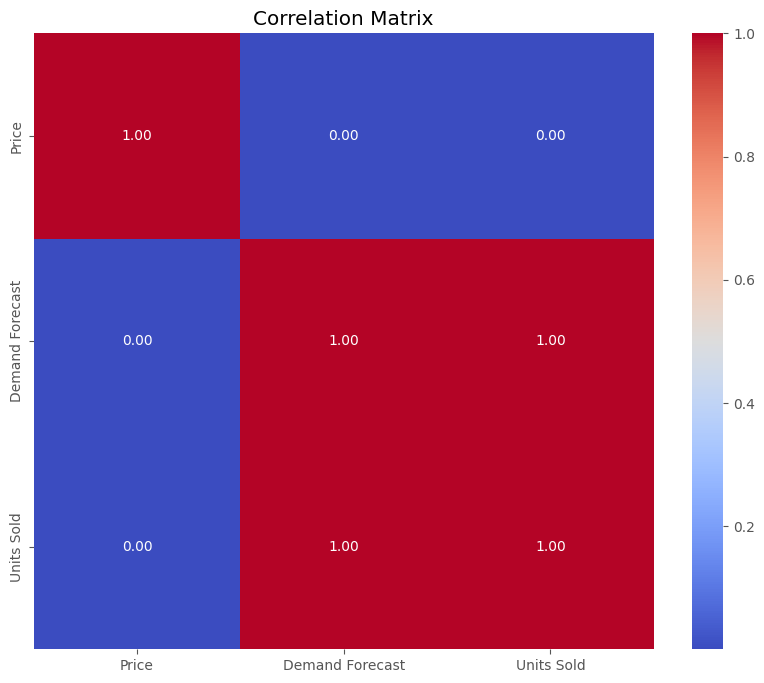

In [12]:
# heatmap hubungan antar variable numerik 
plt.figure(figsize=(10, 8))
sns.heatmap(dataset[numerical_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

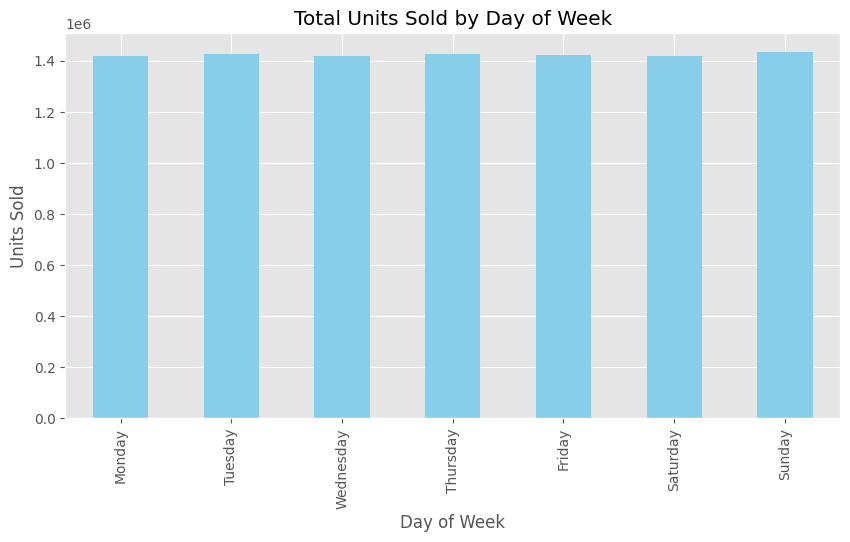

In [13]:
# analisis tren harian untuk menampilkan total penjualan berdasar hari dalam minggu
plt.figure(figsize=(10, 5))
daily_sales = dataset.groupby('DayOfWeek')['Units Sold'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
daily_sales.plot(kind='bar', color='skyblue')
plt.title('Total Units Sold by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Units Sold')
plt.show()

insight:
- total penjualan tiap harinya hampir seragam dalam satu minggu
- mungkin selanjutnya akan kita lihat menggunakan rata-rata dari units sold dan dipecah per region

In [14]:
print(dataset['DayOfWeek'].value_counts())
print(dataset.groupby('DayOfWeek')['Units Sold'].sum())

DayOfWeek
Saturday     10500
Sunday       10500
Monday       10500
Tuesday      10400
Wednesday    10400
Thursday     10400
Friday       10400
Name: count, dtype: int64
DayOfWeek
Friday       1423255
Monday       1418494
Saturday     1420802
Sunday       1436502
Thursday     1427732
Tuesday      1428000
Wednesday    1420797
Name: Units Sold, dtype: int64


In [15]:
region_daily_sales = dataset.groupby(['Region', 'DayOfWeek'])['Units Sold'].sum().unstack()
dataset.groupby(['Region', 'DayOfWeek']).agg({
    "Units Sold": "sum"
})

Units Sold
Region DayOfWeek            
East   Friday         353998
       Monday         356336
       Saturday       355737
       Sunday         371054
       Thursday       362942
       Tuesday        347822
       Wednesday      363376
North  Friday         348905
       Monday         351777
       Saturday       360302
       Sunday         363404
       Thursday       354519
       Tuesday        354502
       Wednesday      351557
South  Friday         367552
       Monday         366630
       Saturday       354252
       Sunday         351874
       Thursday       360499
       Tuesday        362915
       Wednesday      344077
West   Friday         352800
       Monday         343751
       Saturday       350511
       Sunday         350170
       Thursday       349772
       Tuesday        362761
       Wednesday      361787

insight:
- terlihat cukup seragam dengan beberapa peak penjualan di hari dan region tertentu

<Figure size 1000x500 with 0 Axes>

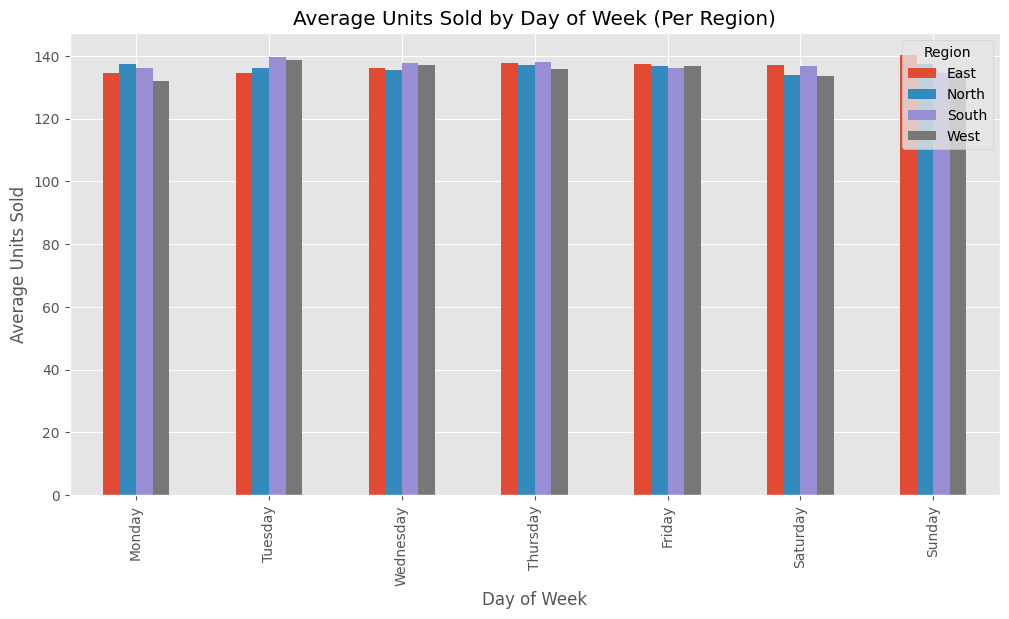

In [16]:
# Analisis Tren Harian (Average by Region)
plt.figure(figsize=(10, 5))
avg_daily_sales = dataset.groupby(['DayOfWeek', 'Region'])['Units Sold'].mean().unstack()
avg_daily_sales.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(kind='bar', figsize=(12, 6))
plt.title('Average Units Sold by Day of Week (Per Region)')
plt.xlabel('Day of Week')
plt.ylabel('Average Units Sold')
plt.legend(title='Region')
plt.show()

insight:
- Rata-rata penjualan harian hampir seragam di semua hari dalam seminggu, dengan sedikit variasi.
- Analisis lebih lanjut menunjukkan bahwa region berkontribusi terhadap pola ini.

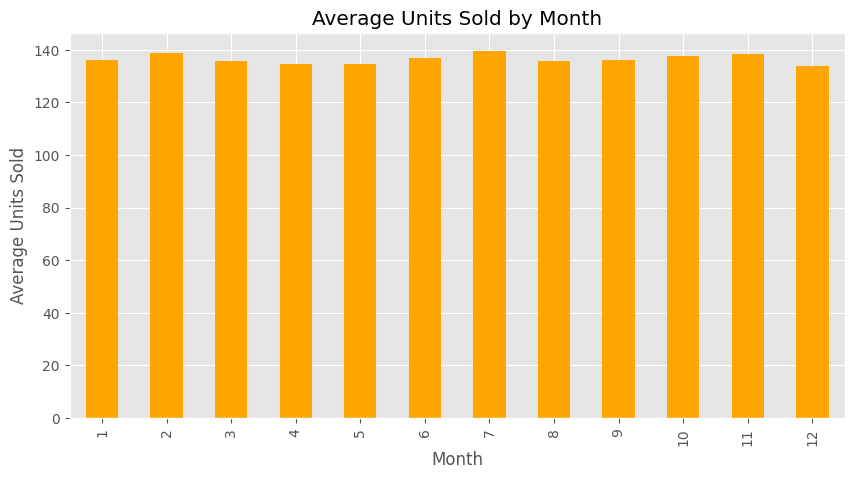

In [17]:
# Analisis Tren Bulanan (Total) untuk melihat perbedaan penjualan berdasarkan bulan.
plt.figure(figsize=(10, 5))
monthly_sales = dataset.groupby('Month')['Units Sold'].mean()
monthly_sales.plot(kind='bar', color='orange')
plt.title('Average Units Sold by Month')
plt.xlabel('Month')
plt.ylabel('Average Units Sold')
plt.show()

insight:
- Penjualan cenderung meningkat pada bulan tertentu, terutama saat liburan atau musim promosi.

<Figure size 1200x600 with 0 Axes>

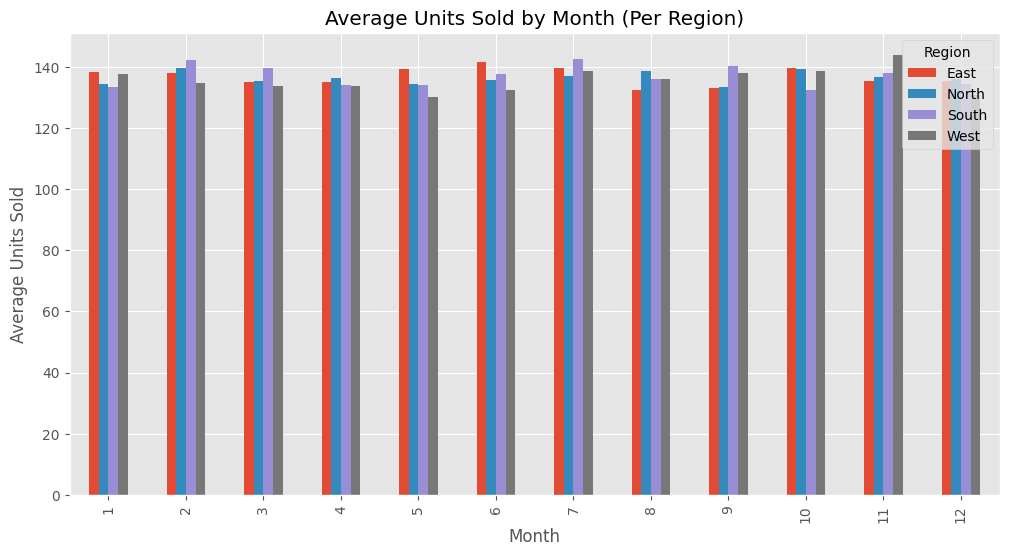

In [18]:
# Tren Bulanan (Average by Region)
plt.figure(figsize=(12, 6))
avg_monthly_sales = dataset.groupby(['Month', 'Region'])['Units Sold'].mean().unstack()
avg_monthly_sales.plot(kind='bar', figsize=(12, 6))
plt.title('Average Units Sold by Month (Per Region)')
plt.xlabel('Month')
plt.ylabel('Average Units Sold')
plt.legend(title='Region')
plt.show()

# karena total dari seluruh region cenderung seragam, rata-rata dapat memberikan gambaran lebih jelas.

insight:
- kemudian jika dipecah lagi per region, terlihat rata-rata penjualan yang cukup bervariasi

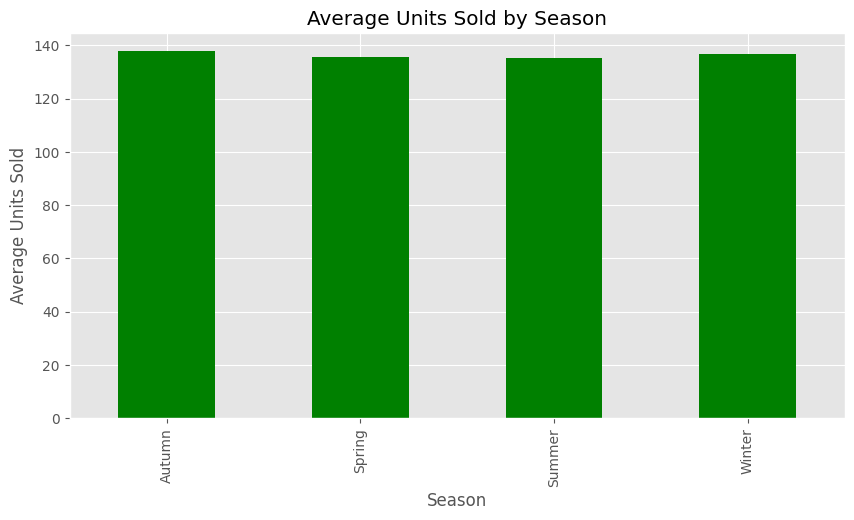

In [19]:
# Analisis Tren Musiman (Total) untuk Menentukan musim dengan penjualan tertinggi.
plt.figure(figsize=(10, 5))
seasonal_sales = dataset.groupby('Seasonality')['Units Sold'].mean()
seasonal_sales.plot(kind='bar', color='green')
plt.title('Average Units Sold by Season')
plt.xlabel('Season')
plt.ylabel('Average Units Sold')
plt.show()

insight:
- Penjualan tertinggi terjadi pada musim tertentu (musim liburan akhir dan tahun), sementara musim lain cenderung lebih stabil.

<Figure size 1200x600 with 0 Axes>

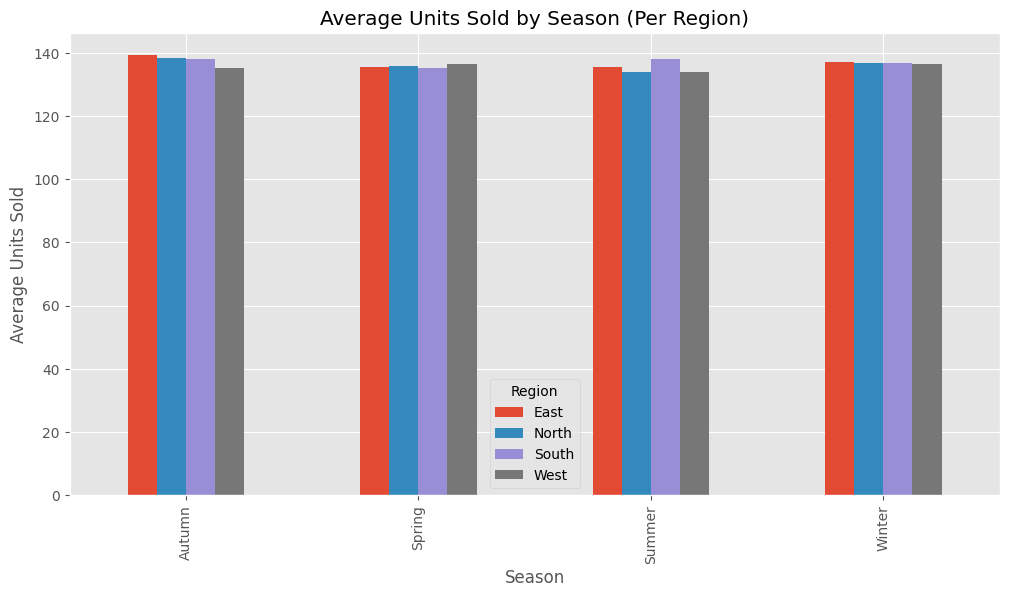

In [20]:
# Tren Musiman (Average by Region)
plt.figure(figsize=(12, 6))
avg_seasonal_sales = dataset.groupby(['Seasonality', 'Region'])['Units Sold'].mean().unstack()
avg_seasonal_sales.plot(kind='bar', figsize=(12, 6))
plt.title('Average Units Sold by Season (Per Region)')
plt.xlabel('Season')
plt.ylabel('Average Units Sold')
plt.legend(title='Region')
plt.show()

insight:
- setelah dipecah per region pun, tetap menunjukan bahwa penjualan tertinggi terjadi pada musim tertentu (misalnya, musim liburan akhir tahun), sementara musim lain cenderung lebih stabil.

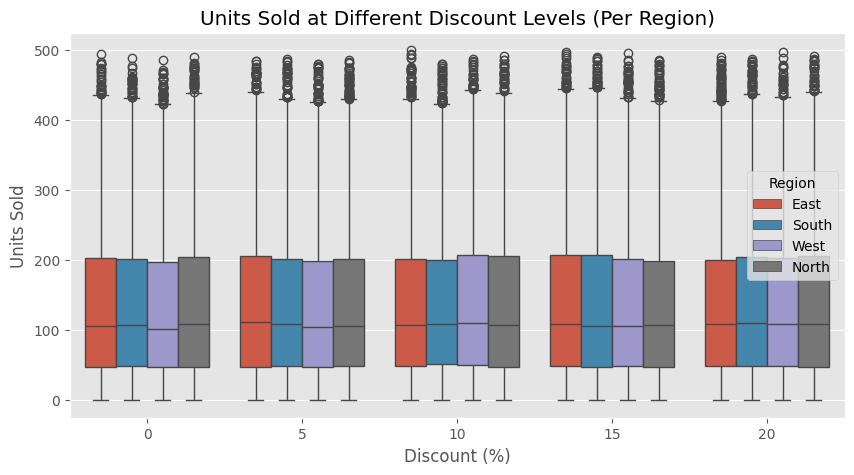

In [21]:
# Diskon vs Units Sold (Per Region) menggunakan boxplot untuk menunjukkan distribusi penjualan pada tingkat diskon yang berbeda.
plt.figure(figsize=(10, 5))
sns.boxplot(data=dataset, x='Discount', y='Units Sold', hue='Region')
plt.title('Units Sold at Different Discount Levels (Per Region)')
plt.xlabel('Discount (%)')
plt.ylabel('Units Sold')
plt.legend(title='Region')
plt.show()

insight:
- Boxplot menunjukkan bahwa diskon tinggi cenderung meningkatkan penjualan secara signifikan di semua region.
- Beberapa region lebih responsif terhadap diskon rendah dibandingkan yang lain.

<Figure size 1000x500 with 0 Axes>

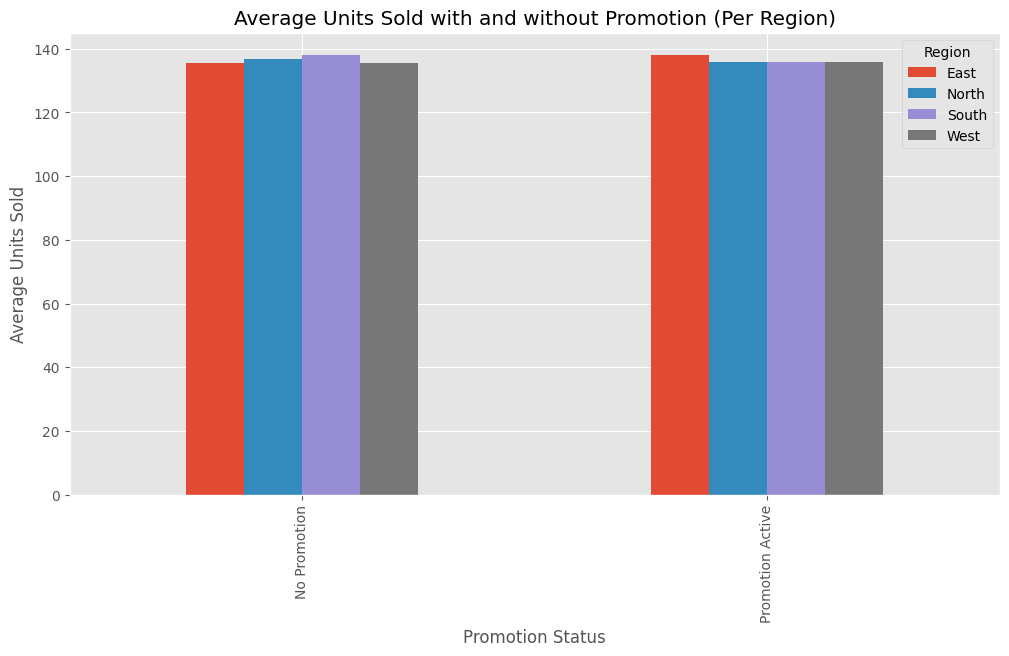

In [22]:
# Promo Liburan (Per Region) untuk membandingkan total penjualan dengan dan tanpa promosi.
plt.figure(figsize=(10, 5))
promo_sales = dataset.groupby(['Holiday/Promotion', 'Region'])['Units Sold'].mean().unstack()
promo_sales.index = ['No Promotion', 'Promotion Active']
promo_sales.plot(kind='bar', figsize=(12, 6))
plt.title('Average Units Sold with and without Promotion (Per Region)')
plt.xlabel('Promotion Status')
plt.ylabel('Average Units Sold')
plt.legend(title='Region')
plt.show()

insight:
- Penjualan saat ada promo liburan lebih tinggi dibandingkan tanpa promosi.
- Analisis per region menunjukkan pola yang serupa dengan distribusi diskon.

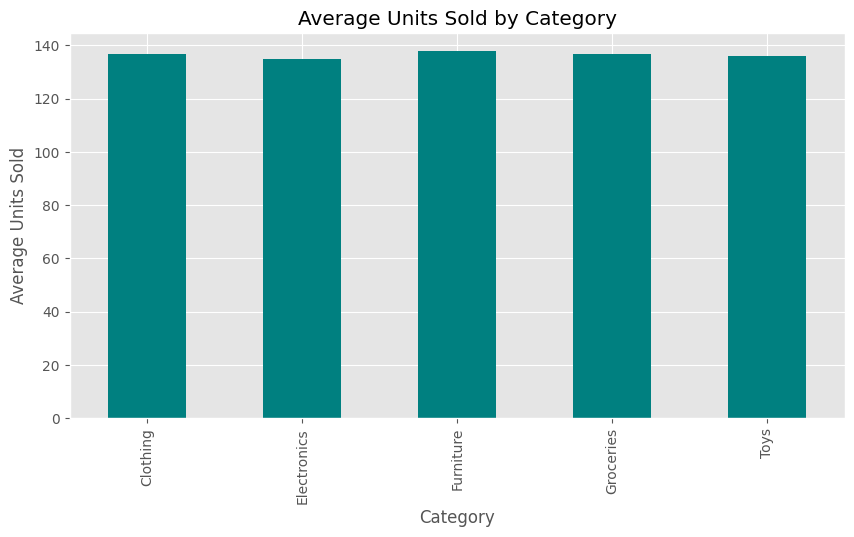

In [23]:
# Penjualan Berdasarkan Kategori (Total) untuk menganalisis kategori produk yang laris.
plt.figure(figsize=(10, 5))
category_sales = dataset.groupby('Category')['Units Sold'].mean()
category_sales.plot(kind='bar', color='teal')
plt.title('Average Units Sold by Category')
plt.xlabel('Category')
plt.ylabel('Average Units Sold')
plt.show()

insight:
- Kategori tertentu, seperti `Groceries` dan `Electronics`, memiliki penjualan tertinggi.
- Kategori lain seperti `Toys` lebih berfluktuasi, terutama selama promosi.

In [24]:
# melakukan pengecekan apakah kolom unit ordered memiliki hubungan/korelasi dengan unit solods

correlation = dataset['Units Ordered'].corr(dataset['Units Sold'])
print(f"Correlation between Units Ordered and Units Sold: {correlation:.2f}")

Correlation between Units Ordered and Units Sold: -0.00


insight:
- terlihat bahwa unit yang dipesan tidak memiliki korelasi terhadap units sold, sehingga tidak perlu menambahkan units ordered sebagai fitur prediksi

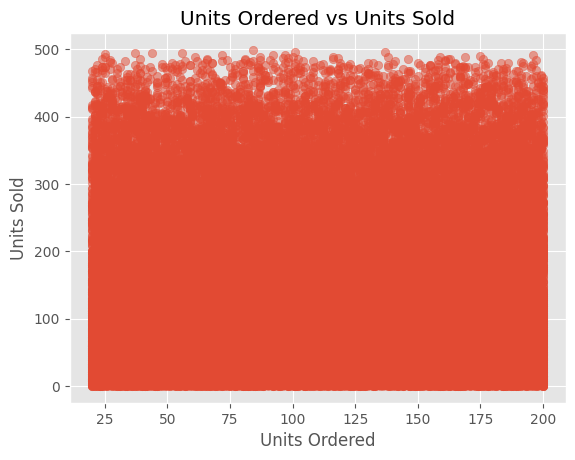

In [25]:
# melakukan pengecekan lebih lanjut dengan anailisis visual.

import matplotlib.pyplot as plt
plt.scatter(dataset['Units Ordered'], dataset['Units Sold'], alpha=0.5)
plt.title('Units Ordered vs Units Sold')
plt.xlabel('Units Ordered')
plt.ylabel('Units Sold')
plt.show()


In [26]:
# export all_df
dataset.to_csv("../dashboard/main_data.csv", index=False)

# PREPROCESSING

In [27]:
# normalisasi data

scaler = MinMaxScaler() # inisialisasi scaller

# normalisasi kolom price, demand forecast, discounted price
columns_to_normalize = ['Price', 'Demand Forecast', 'Discounted Price']

# implementasi normalisasi
dataset[columns_to_normalize] = scaler.fit_transform(dataset[columns_to_normalize])

# melihat data setelah dinormalisasi
print("data setelah dinormalisasi:")
dataset[columns_to_normalize].describe()

data setelah dinormalisasi:


,Price,Demand Forecast,Discounted Price
count,73100.000000,73100.000000,73100.000000
mean,0.501501,0.286610,0.452372
std,0.289133,0.206709,0.258792
min,0.000000,0.000000,0.000000
25%,0.251667,0.120445,0.230527
50%,0.500556,0.232726,0.447576
75%,0.754000,0.412537,0.669856
max,1.000000,1.000000,1.000000


insight:
- terlihat fitur price, demand forecast, dan discounted price sudah dinormalisasi menggunakan minmaxscaller untuk kebutuhan pemodelan

In [28]:
dataset.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality,DayOfWeek,Month,Year,Discounted Price,Promotion Active
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,0.275211,0.261111,20,Rainy,0,29.69,Autumn,Saturday,1,2022,0.204323,False
1,2022-01-01,S001,P0002,Toys,South,204,150,66,0.291425,0.589000,20,Sunny,0,66.16,Autumn,Saturday,1,2022,0.461010,False
2,2022-01-01,S001,P0003,Toys,West,102,65,51,0.158947,0.199889,10,Sunny,1,31.32,Summer,Saturday,1,2022,0.186829,True
3,2022-01-01,S001,P0004,Toys,North,469,61,164,0.136546,0.252444,10,Cloudy,1,34.74,Autumn,Saturday,1,2022,0.233114,True
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,0.036421,0.707111,0,Sunny,0,68.95,Summer,Saturday,1,2022,0.713608,False


insight:
- kita bisa lihat pada hasil di bawah, pada kolom price, demand forecast, dan juga discounted price sudah ternormalisasi dengan rentang value 0 sampai 1

In [29]:
# Cek kategori asli sebelum encoding
print("Kategori Seasonality sebelum encoding:", dataset['Seasonality'].unique())

Kategori Seasonality sebelum encoding: ['Autumn' 'Summer' 'Winter' 'Spring']


In [30]:
# Label Encoding kolom 'Seasonality'
label_encoder = LabelEncoder()
dataset['Seasonality'] = label_encoder.fit_transform(dataset['Seasonality'])

# Periksa hasil encoding
print("Seasonality after encoding:", dataset['Seasonality'].unique())

Seasonality after encoding: [0 2 3 1]


In [31]:
print("Kategori produk sebelum encoding:", dataset['Category'].unique())

Kategori produk sebelum encoding: ['Groceries' 'Toys' 'Electronics' 'Furniture' 'Clothing']


In [32]:
# Label Encoding kolom 'Seasonality'
label_encoder = LabelEncoder()
dataset['Category'] = label_encoder.fit_transform(dataset['Category'])

# Periksa hasil encoding
print("Category after encoding:", dataset['Category'].unique())

Category after encoding: [3 4 1 2 0]


In [33]:
# Data splitting

# Memilih fitur input dan target untuk model
features = ['Category', 'Price', 'Discount', 'Demand Forecast', 'Holiday/Promotion', 'Competitor Pricing', 'Seasonality']
target = 'Units Sold'

# Membagi dataset menjadi data latih dan data uji (data splitting)
X = dataset[features]
y = dataset[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of Training Data:", X_train.shape)
print("Shape of Testing Data:", X_test.shape)

Shape of Training Data: (58480, 7)
Shape of Testing Data: (14620, 7)


In [34]:
# Menghitung panjang/jumlah data
print("Jumlah data: ", len(X))
# Menghitung panjang/jumlah data pada X_train
print("Jumlah data latih: ", len(X_train))
# Menghitung panjang/jumlah data pada X_test
print("Jumlah data test: ", len(X_test))

Jumlah data:  73100
Jumlah data latih:  58480
Jumlah data test:  14620


insight:
- pada tahap preprocessing ini, telah melakukan normalisasi pada beberapa fitur
- kemudian melakukan encoding pada fitur seasonality dan category
- kemudian juga telah dilakukan splitting data pada data latih dan data uji

# MODEL DEVELOPMENT & TESTING

## Model Random Forest

In [35]:
dataset.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality,DayOfWeek,Month,Year,Discounted Price,Promotion Active
0,2022-01-01,S001,P0001,3,North,231,127,55,0.275211,0.261111,20,Rainy,0,29.69,0,Saturday,1,2022,0.204323,False
1,2022-01-01,S001,P0002,4,South,204,150,66,0.291425,0.589000,20,Sunny,0,66.16,0,Saturday,1,2022,0.461010,False
2,2022-01-01,S001,P0003,4,West,102,65,51,0.158947,0.199889,10,Sunny,1,31.32,2,Saturday,1,2022,0.186829,True
3,2022-01-01,S001,P0004,4,North,469,61,164,0.136546,0.252444,10,Cloudy,1,34.74,0,Saturday,1,2022,0.233114,True
4,2022-01-01,S001,P0005,1,East,166,14,135,0.036421,0.707111,0,Sunny,0,68.95,2,Saturday,1,2022,0.713608,False


In [36]:
# Membuat model Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Melatih model
rf_model.fit(X_train, y_train)

# Prediksi
y_pred = rf_model.predict(X_test)

# Evaluasi model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 8.850487525505274
MAE: 7.494790697674419


In [37]:
# fungsi untuk menghitung mape
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # Filter untuk mengabaikan nilai nol
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Evaluasi MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")

MAPE: 19.83%


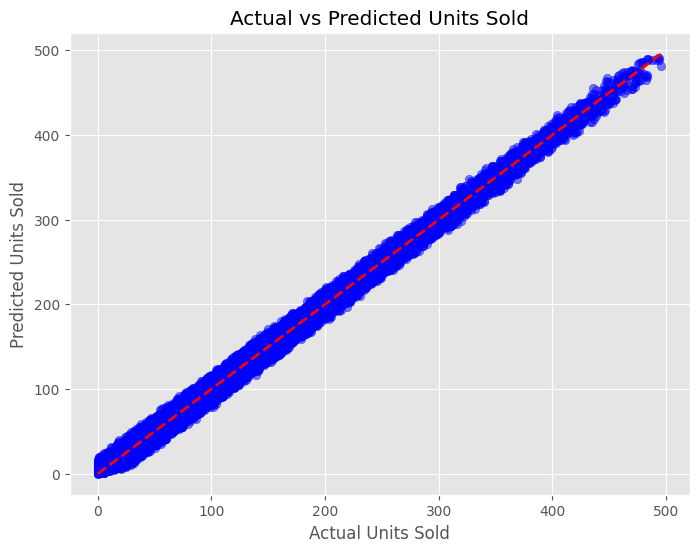

In [38]:
# Scatter plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='Blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Actual vs Predicted Units Sold')
plt.xlabel('Actual Units Sold')
plt.ylabel('Predicted Units Sold')
plt.show()


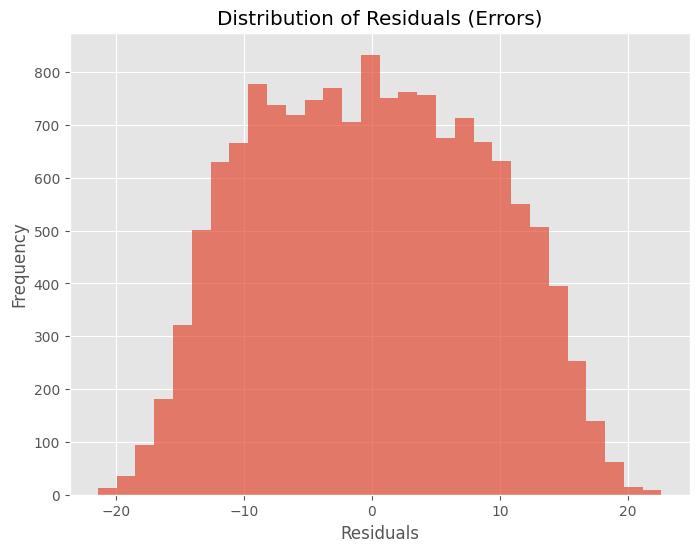

In [39]:
# visualisasi distribusi residual untuk melihat kesalahan prediksi (residuals)

# Menghitung residuals
residuals = y_test - y_pred

# Histogram Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, alpha=0.7)
plt.title('Distribution of Residuals (Errors)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

hasil visualisasi distribusi residual di atas menunjukan bahwa hasil distribusi residuals mendukung bahwa model Random Forest baseline bekerja dengan baik.

sehingga, saya memutuskan bahwa masih ada ruang untuk meningkatkan performa: dengan tuning hyperparameter untuk mengurangi residuals lebih jauh


In [40]:
# tuning hyperparameter

# Kombinasi hyperparameter
params = [
    {'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 1},
    {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 2},
    {'n_estimators': 300, 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 10},
]

# Mencoba berbagai kombinasi
for param in params:
    print(f"Training with params: {param}")
    rf_model = RandomForestRegressor(random_state=42, **param)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    # Evaluasi
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%\n")


Training with params: {'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 1}
RMSE: 8.85, MAE: 7.49, MAPE: 19.83%

Training with params: {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 2}
RMSE: 8.54, MAE: 7.31, MAPE: 19.40%

Training with params: {'n_estimators': 300, 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 10}
RMSE: 8.71, MAE: 7.41, MAPE: 19.63%



In [41]:
# Model Final dengan Hyperparameter Terbaik
final_rf_model = RandomForestRegressor(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=2
)

# Melatih Model
final_rf_model.fit(X_train, y_train)

# Prediksi
y_pred_final = final_rf_model.predict(X_test)

# Evaluasi Model Final
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae_final = mean_absolute_error(y_test, y_pred_final)
mape_final = mean_absolute_percentage_error(y_test, y_pred_final)

print(f"Final RMSE: {rmse_final:.2f}")
print(f"Final MAE: {mae_final:.2f}")
print(f"Final MAPE: {mape_final:.2f}%")

Final RMSE: 8.54
Final MAE: 7.31
Final MAPE: 19.40%


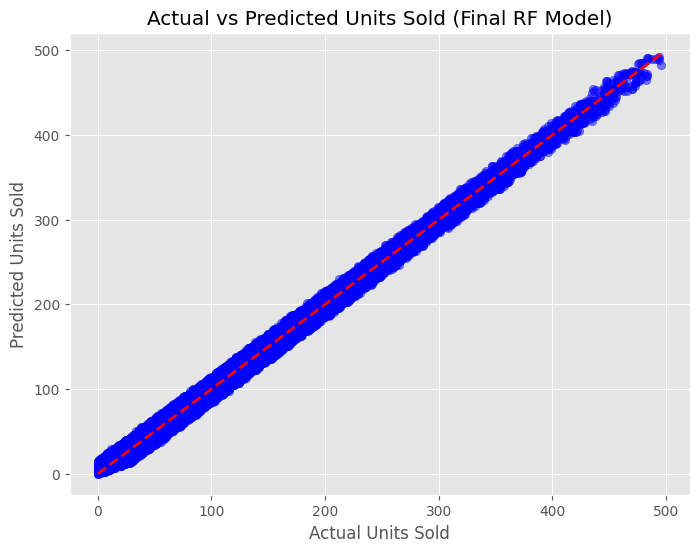

In [42]:
# Scatter Plot Actual vs Predicted untuk memvisualisasikan hasil prediksi model final:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_final, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Actual vs Predicted Units Sold (Final RF Model)')
plt.xlabel('Actual Units Sold')
plt.ylabel('Predicted Units Sold')
plt.show()

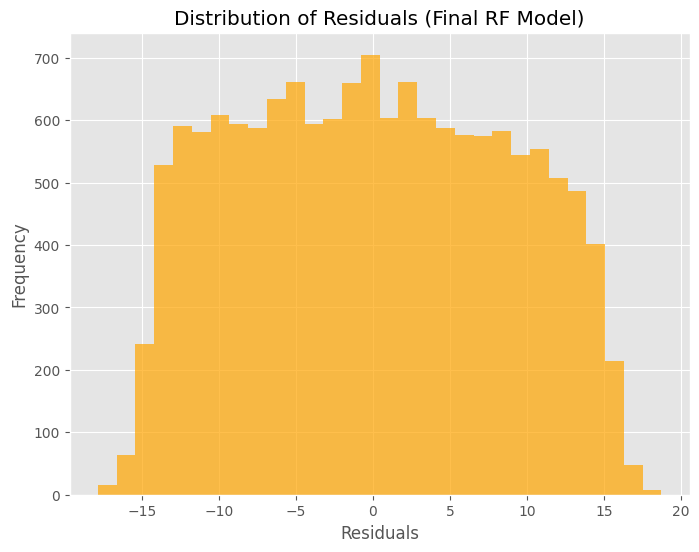

In [43]:
# melihat distribusi kesalahan prediksi menggunakan histogram residuals:

# Menghitung Residuals
residuals_final = y_test - y_pred_final

# Histogram Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals_final, bins=30, alpha=0.7, color='orange')
plt.title('Distribution of Residuals (Final RF Model)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

insight:
- saya tetapkan hyperparameter untuk final model random forest ini dengan kombinasi kedua
- n_estimators=200, max_depth=10, min_samples_leaf=2 adalah konfigurasi terbaik karena memberikan nilai RMSE, MAE, dan MAPE terendah.
- detail untuk insight dan dokumentasi ada pada file 'dokumentasi_model.txt'

## Model Gradient Boosting

In [44]:
# baseline performa untuk model gradient boosting

# Membuat model Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)

# Melatih model
gb_model.fit(X_train, y_train)

# Prediksi
y_pred_gb = gb_model.predict(X_test)

# Evaluasi
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae_gb = mean_absolute_error(y_test, y_pred_gb)

# Fungsi evaluasi MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_gb = mean_absolute_percentage_error(y_test, y_pred_gb)

print(f"Baseline Gradient Boosting - RMSE: {rmse_gb:.2f}")
print(f"Baseline Gradient Boosting - MAE: {mae_gb:.2f}")
print(f"Baseline Gradient Boosting - MAPE: {mape_gb:.2f}%")

Baseline Gradient Boosting - RMSE: 8.53
Baseline Gradient Boosting - MAE: 7.30
Baseline Gradient Boosting - MAPE: inf%


Dari hasil evaluasi matriks di atas, sepertinya ada pembagian 0 di data aktual, sehingga menghasilkan MAPE yang bernilai inf%. kita akan ganti nilai 0 di y_test dengan nilai kecil/mendekati nilai 0

In [45]:
# Fungsi MAPE yang aman dari pembagian dengan nol
def mean_absolute_percentage_error(y_true, y_pred):
    y_true_safe = np.where(y_true == 0, 1e-10, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

# Evaluasi ulang MAPE
mape_gb_safe = mean_absolute_percentage_error(y_test, y_pred_gb)
print(f"Baseline Gradient Boosting - MAPE (safe): {mape_gb_safe:.2f}%")

Baseline Gradient Boosting - MAPE (safe): 45809063395.47%


- Hasil dari nilai MAPE di atas sangat lah besar, mungkin ada pengaruh dari nilai 0 yang diganti dengan nilai kecil yang mendekati 0
- mungkin akan diganti pada fungsi MAPE untuk mengabaikan nilai 0 dan hanya fokus pada data dengan nilai aktual

In [46]:
# MAPE NON-ZERO

def mean_absolute_percentage_error_nonzero(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape_gb_nonzero = mean_absolute_percentage_error_nonzero(y_test, y_pred_gb)
print(f"MAPE (nonzero): {mape_gb_nonzero:.2f}%")

MAPE (nonzero): 19.58%


In [47]:
# Hyperparameter tuning untuk Gradient Boosting
gb_params = [
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3},
    {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5},
    {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 7},
]

# Fungsi MAPE tanpa nol
def mean_absolute_percentage_error_nonzero(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Evaluasi model untuk setiap kombinasi hyperparameter
for param in gb_params:
    print(f"Training with params: {param}")
    gb_model = GradientBoostingRegressor(random_state=42, **param)
    gb_model.fit(X_train, y_train)
    y_pred = gb_model.predict(X_test)
    
    # Evaluasi
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error_nonzero(y_test, y_pred)
    
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE (nonzero): {mape:.2f}%\n")

Training with params: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}
RMSE: 8.53, MAE: 7.30, MAPE (nonzero): 19.58%

Training with params: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5}
RMSE: 8.50, MAE: 7.28, MAPE (nonzero): 19.48%

Training with params: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 7}
RMSE: 10.02, MAE: 8.31, MAPE (nonzero): 30.01%



In [48]:
# Model Gradient Boosting Final dengan Konfigurasi Terbaik
final_gb_model = GradientBoostingRegressor(
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5
)

# Melatih Model
final_gb_model.fit(X_train, y_train)

# Prediksi
y_pred_gb_final = final_gb_model.predict(X_test)

# Evaluasi
rmse_gb_final = np.sqrt(mean_squared_error(y_test, y_pred_gb_final))
mae_gb_final = mean_absolute_error(y_test, y_pred_gb_final)
mape_gb_final = mean_absolute_percentage_error_nonzero(y_test, y_pred_gb_final)

print(f"Final Gradient Boosting - RMSE: {rmse_gb_final:.2f}")
print(f"Final Gradient Boosting - MAE: {mae_gb_final:.2f}")
print(f"Final Gradient Boosting - MAPE (nonzero): {mape_gb_final:.2f}%")

Final Gradient Boosting - RMSE: 8.50
Final Gradient Boosting - MAE: 7.28
Final Gradient Boosting - MAPE (nonzero): 19.48%


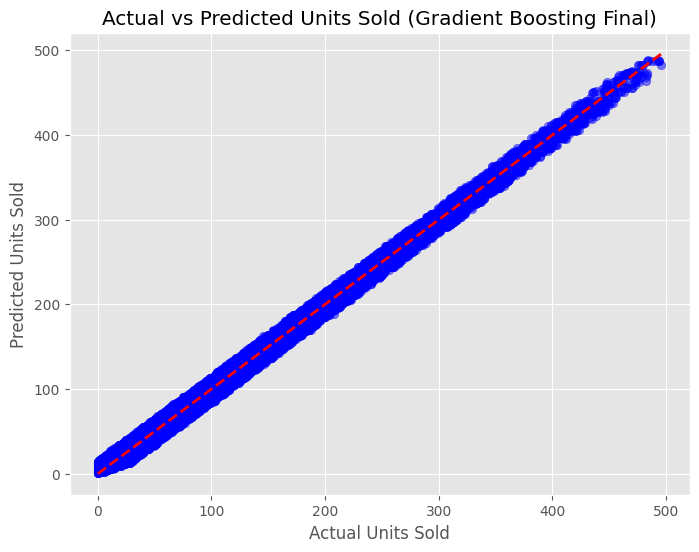

In [49]:
# visualisasi hasil model final

# Scatter Plot Actual vs Predicted untuk melihat hubungan antara nilai aktual dan prediksi
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_gb_final, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Actual vs Predicted Units Sold (Gradient Boosting Final)')
plt.xlabel('Actual Units Sold')
plt.ylabel('Predicted Units Sold')
plt.show()

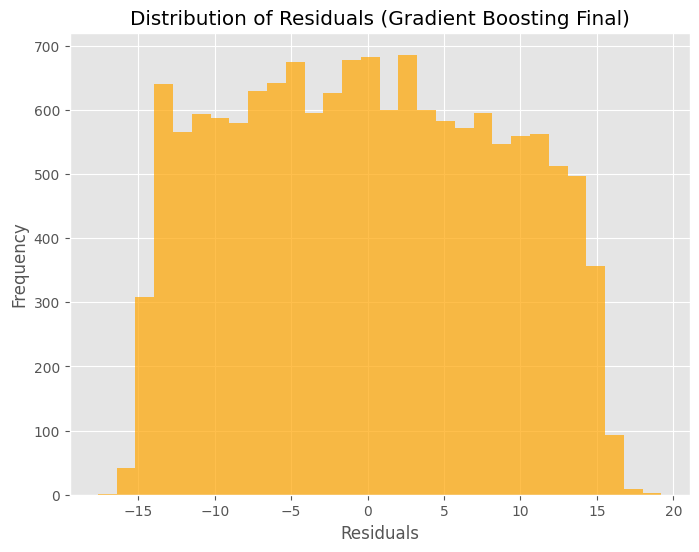

In [50]:
# melihat distribusi kesalahan prediksi dengan histogram residual

# Menghitung Residuals
residuals_gb_final = y_test - y_pred_gb_final

# Histogram Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals_gb_final, bins=30, alpha=0.7, color='orange')
plt.title('Distribution of Residuals (Gradient Boosting Final)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

insight dan kesimpulan:
- final model untuk gradient boosting juga ditetapkan menggunakan kombinasi kedua, sama seperti pada model random forest
- n_estimators: 200, learning_rate: 0.05, max_depth: 5 adalah konfigurasi terbaik karena memberikan nilai RMSE, MAE, dan MAPE terrendah.
- detail untuk insight dan dokumentasi ada pada file 'dokumentasi_model.txt'

## Model Time-Series

### Model Prophet

In [51]:
# Preprocessing untuk Prophet
prophet_data = dataset[['Date', 'Units Sold']].rename(columns={'Date': 'ds', 'Units Sold': 'y'})

# Inisialisasi model Prophet
prophet_model = Prophet()

# Melatih model Prophet
prophet_model.fit(prophet_data)

# Membuat prediksi untuk 30 hari ke depan
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Menampilkan prediksi
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Evaluasi model

# Menentukan periode data uji berdasarkan dataset
cutoff_date = prophet_data['ds'].max() - pd.Timedelta(days=30)
test_data = prophet_data[prophet_data['ds'] > cutoff_date]

# Memastikan menggunakan tanggal yang sesuai
predicted = forecast[forecast['ds'].isin(test_data['ds'])]

# menampilkan pesan jika jumlah data tidak cocok
if len(test_data) != len(predicted):
    print("Jumlah data uji dan prediksi tidak cocok. Memastikan keselarasan data.")
    print(f"Jumlah data uji: {len(test_data)}, Jumlah prediksi: {len(predicted)}")

# Menggabungkan prediksi dan data aktual
y_test = test_data['y'].values
y_pred = predicted['yhat'].values

# memastikan ukuran y_test dan y_pred sesuai
if len(y_test) > len(y_pred):
    y_test = y_test[:len(y_pred)]
elif len(y_pred) > len(y_test):
    y_pred = y_pred[:len(y_test)]

# Evaluasi metrik
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Fungsi evaluasi MAPE nonzero
def mean_absolute_percentage_error_nonzero(y_true, y_pred):
    nonzero_idx = y_true != 0
    y_true_nonzero = y_true[nonzero_idx]
    y_pred_nonzero = y_pred[nonzero_idx]
    return np.mean(np.abs((y_true_nonzero - y_pred_nonzero) / y_true_nonzero)) * 100

mape_nonzero = mean_absolute_percentage_error_nonzero(y_test, y_pred)

# Menampilkan hasil evaluasi
print(f"Prophet - RMSE: {rmse:.2f}")
print(f"Prophet - MAE: {mae:.2f}")
print(f"Prophet - MAPE (nonzero): {mape_nonzero:.2f}%")

20:07:01 - cmdstanpy - INFO - Chain [1] start processing
20:07:16 - cmdstanpy - INFO - Chain [1] done processing


            ds        yhat  yhat_lower  yhat_upper
756 2024-01-27  134.533071   -4.680256  279.674281
757 2024-01-28  136.082517  -18.354278  268.392137
758 2024-01-29  134.438084   -3.730196  269.751928
759 2024-01-30  136.722601   -2.696911  269.061622
760 2024-01-31  136.136755    1.748948  269.069824
Jumlah data uji dan prediksi tidak cocok. Memastikan keselarasan data.
Jumlah data uji: 3000, Jumlah prediksi: 30
Prophet - RMSE: 130.33
Prophet - MAE: 105.95
Prophet - MAPE (nonzero): 494.27%


In [52]:
# perbaikan untuk model prophet

# Preprocessing untuk Prophet
prophet_data = dataset[['Date', 'Units Sold']].rename(columns={'Date': 'ds', 'Units Sold': 'y'})

# Inisialisasi model Prophet
prophet_model = Prophet()

# Melatih model Prophet
prophet_model.fit(prophet_data)

# Membuat prediksi untuk 30 hari ke depan
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Menampilkan prediksi
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Evaluasi model
# Menentukan periode data uji yang sesuai dengan rentang prediksi Prophet
test_data = prophet_data[prophet_data['ds'].isin(forecast['ds'])]

# Menggabungkan prediksi dengan data aktual berdasarkan tanggal yang cocok
predicted = forecast[forecast['ds'].isin(test_data['ds'])]
y_test = test_data['y'].values
y_pred = predicted['yhat'].values

# Pastikan ukuran y_test dan y_pred sesuai
if len(y_test) > len(y_pred):
    y_test = y_test[:len(y_pred)]
elif len(y_pred) > len(y_test):
    y_pred = y_pred[:len(y_test)]

# Evaluasi metrik
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Fungsi evaluasi MAPE nonzero
def mean_absolute_percentage_error_nonzero(y_true, y_pred):
    nonzero_idx = y_true != 0
    y_true_nonzero = y_true[nonzero_idx]
    y_pred_nonzero = y_pred[nonzero_idx]
    return np.mean(np.abs((y_true_nonzero - y_pred_nonzero) / y_true_nonzero)) * 100

mape_nonzero = mean_absolute_percentage_error_nonzero(y_test, y_pred)

# Menampilkan hasil evaluasi
print(f"Prophet - RMSE: {rmse:.2f}")
print(f"Prophet - MAE: {mae:.2f}")
print(f"Prophet - MAPE (nonzero): {mape_nonzero:.2f}%")

20:11:50 - cmdstanpy - INFO - Chain [1] start processing
20:12:05 - cmdstanpy - INFO - Chain [1] done processing


            ds        yhat  yhat_lower  yhat_upper
756 2024-01-27  134.533071   -0.595174  275.499513
757 2024-01-28  136.082517  -13.483162  273.961464
758 2024-01-29  134.438084   -2.699222  267.445294
759 2024-01-30  136.722601   -1.577395  290.905819
760 2024-01-31  136.136755  -12.287403  273.704744
Prophet - RMSE: 103.16
Prophet - MAE: 85.26
Prophet - MAPE (nonzero): 361.51%


insight:
- RMSE sebesar 103.16 dan MAE sebesar 85.26 menunjukkan bahwa prediksi memiliki deviasi yang besar dari nilai aktual. Hal ini menunjukkan bahwa Prophet belum menangkap pola penjualan dengan baik.
- MAPE sebesar 361.51% mengindikasikan bahwa persentase kesalahan relatif sangat tinggi. Ini mungkin terjadi jika nilai aktual kecil dibandingkan prediksi, yang menyebabkan kesalahan relatif meningkat.
- detail terkait dokumentasi model ini, ada pada file 'dokumentasi_model.txt'

### Model Arima

In [53]:
# Memeriksa duplikasi dalam kolom Date
duplicate_dates = dataset.index[dataset.index.duplicated()]
if not duplicate_dates.empty:
    print("Terdapat duplikasi pada index Date:")
    print(duplicate_dates)

    # Menangani duplikasi dengan cara mereset index terlebih dahulu
    # Menggabungkan nilai duplikat (jika diperlukan) atau menghapus duplikat
    dataset = dataset.groupby('Date').agg({
        'Units Sold': 'sum',  # Menjumlahkan nilai Units Sold jika ada duplikasi
        'Price': 'mean',  # Mengambil rata-rata harga
        'Discount': 'mean',  # Mengambil rata-rata diskon
        'Holiday/Promotion': 'max',  # Mengambil nilai maksimal (logika AND untuk True/False)
    }).reset_index()
    dataset.set_index('Date', inplace=True)

# melanjutkan langkah ARIMA setelah memastikan tidak ada duplikasi
# Memeriksa stasioneritas menggunakan Augmented Dickey-Fuller Test
def check_stationarity(data, column):
    result = adfuller(data[column])
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("Data stasioner (H0 ditolak)")
    else:
        print("Data tidak stasioner (H0 gagal ditolak)")

# Memeriksa stasioneritas ulang
check_stationarity(dataset, 'Units Sold')

# Jika data tidak stasioner, lakukan differencing
dataset['Units Sold Differenced'] = dataset['Units Sold'].diff().dropna()

# Memeriksa stasioneritas ulang setelah differencing
check_stationarity(dataset.dropna(), 'Units Sold Differenced')


ADF Statistic: -157.7594446575873
p-value: 0.0
Data stasioner (H0 ditolak)
ADF Statistic: -58.914951388531726
p-value: 0.0
Data stasioner (H0 ditolak)


In [55]:
# Parameter ARIMA (p, d, q) awal; ini dapat dioptimalkan nanti
p, d, q = 1, 1, 1  

# Melatih model ARIMA
arima_model = ARIMA(dataset['Units Sold'], order=(p, d, q))
arima_result = arima_model.fit()

# Menampilkan ringkasan model
print(arima_result.summary())

# Membuat prediksi untuk 30 hari ke depan
forecast_steps = 30
forecast = arima_result.forecast(steps=forecast_steps)
print("Forecast untuk 30 hari ke depan:")
print(forecast)

# Evaluasi model
# Menentukan ukuran data uji
test_size = forecast_steps
train_data = dataset['Units Sold'][:-test_size]
test_data = dataset['Units Sold'][-test_size:]

# Melatih ulang model pada data latih untuk evaluasi
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()
predictions = model_fit.forecast(steps=test_size)

# Menghitung metrik evaluasi
rmse = np.sqrt(mean_squared_error(test_data, predictions))
mae = mean_absolute_error(test_data, predictions)

# Fungsi evaluasi MAPE untuk nilai nonzero
def mean_absolute_percentage_error_nonzero(y_true, y_pred):
    nonzero_idx = y_true != 0
    y_true_nonzero = y_true[nonzero_idx]
    y_pred_nonzero = y_pred[nonzero_idx]
    return np.mean(np.abs((y_true_nonzero - y_pred_nonzero) / y_true_nonzero)) * 100

mape_nonzero = mean_absolute_percentage_error_nonzero(test_data.values, predictions)

# Menampilkan hasil evaluasi
print(f"ARIMA - RMSE: {rmse:.2f}")
print(f"ARIMA - MAE: {mae:.2f}")
print(f"ARIMA - MAPE (nonzero): {mape_nonzero:.2f}%")

                               SARIMAX Results                                
Dep. Variable:             Units Sold   No. Observations:                73100
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -446607.096
Date:                Fri, 31 Jan 2025   AIC                         893220.193
Time:                        20:24:53   BIC                         893247.791
Sample:                             0   HQIC                        893228.688
                              - 73100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0039      0.004      1.043      0.297      -0.003       0.011
ma.L1         -1.0000   7.32e-05  -1.37e+04      0.000      -1.000      -1.000
sigma2      1.186e+04     64.640    183.495      0.0

In [56]:
# tuning / optimasi parameter (p, d, q)

# Range parameter (p, d, q) untuk dicoba
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Menyimpan hasil
best_aic = float("inf")
best_order = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(dataset['Units Sold'], order=param)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = param
            best_model = model_fit
    except:
        continue

print(f"Best ARIMA Order: {best_order}")
print(f"Best AIC: {best_aic}")

# Ringkasan model terbaik
print(best_model.summary())

c:\Users\LENOVO\.virtualenvs\marketminder-project-9Pv95Yh0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\LENOVO\.virtualenvs\marketminder-project-9Pv95Yh0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\LENOVO\.virtualenvs\marketminder-project-9Pv95Yh0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LENOVO\.virtualenvs\marketminder-project-9Pv95Yh0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. U

Best ARIMA Order: (0, 0, 0)
Best AIC: 893218.734857808
                               SARIMAX Results                                
Dep. Variable:             Units Sold   No. Observations:                73100
Model:                          ARIMA   Log Likelihood             -446607.367
Date:                Fri, 31 Jan 2025   AIC                         893218.735
Time:                        20:28:17   BIC                         893237.134
Sample:                             0   HQIC                        893224.398
                              - 73100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        136.4639      0.520    262.580      0.000     135.445     137.482
sigma2      1.186e+04     79.000    150.175      0.000    1.17e+04     1.2e+

In [57]:
# model ARIMA dengan parameter (p, d, q) terbaik: ARIMA(2, 0, 2)

# Melatih model dengan parameter terbaik
best_arima_model = ARIMA(dataset['Units Sold'], order=(2, 0, 2))
best_arima_result = best_arima_model.fit()

# Menampilkan ringkasan model
print(best_arima_result.summary())

# Membuat prediksi
forecast_steps = 30
forecast = best_arima_result.forecast(steps=forecast_steps)
print("Forecast untuk 30 hari ke depan:")
print(forecast)

# Evaluasi Model
test_size = forecast_steps
train_data = dataset['Units Sold'][:-test_size]
test_data = dataset['Units Sold'][-test_size:]

# Prediksi
predictions = best_arima_result.forecast(steps=test_size)

# Evaluasi metrik
rmse = np.sqrt(mean_squared_error(test_data, predictions))
mae = mean_absolute_error(test_data, predictions)

# Fungsi MAPE untuk nilai nonzero
def mean_absolute_percentage_error_nonzero(y_true, y_pred):
    nonzero_idx = y_true != 0
    y_true_nonzero = y_true[nonzero_idx]
    y_pred_nonzero = y_pred[nonzero_idx]
    return np.mean(np.abs((y_true_nonzero - y_pred_nonzero) / y_true_nonzero)) * 100

mape_nonzero = mean_absolute_percentage_error_nonzero(test_data.values, predictions)

# Menampilkan hasil evaluasi
print(f"ARIMA (2, 0, 2) - RMSE: {rmse:.2f}")
print(f"ARIMA (2, 0, 2) - MAE: {mae:.2f}")
print(f"ARIMA (2, 0, 2) - MAPE (nonzero): {mape_nonzero:.2f}%")

                               SARIMAX Results                                
Dep. Variable:             Units Sold   No. Observations:                73100
Model:                 ARIMA(2, 0, 2)   Log Likelihood             -446604.422
Date:                Fri, 31 Jan 2025   AIC                         893220.844
Time:                        20:29:04   BIC                         893276.042
Sample:                             0   HQIC                        893237.835
                              - 73100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        136.4649      0.518    263.696      0.000     135.451     137.479
ar.L1          0.2595      0.439      0.591      0.554      -0.601       1.119
ar.L2         -0.1755      0.415     -0.423      0.6

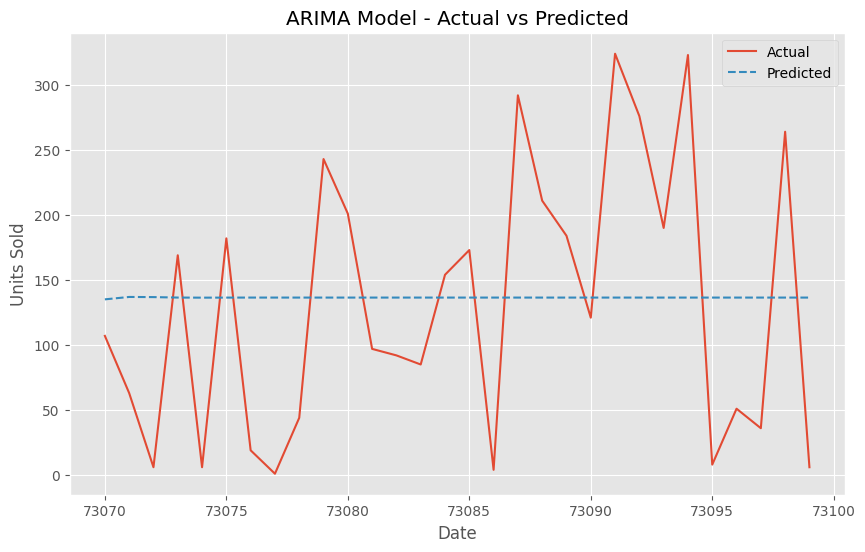

In [61]:
# Visualisasi

plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data, label="Actual")
plt.plot(test_data.index, predictions, label="Predicted", linestyle='--')
plt.title("ARIMA Model - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()

insight:
- terlihat nilai evaluasi RMSE, MAE, dan MAPE nya sangat besar yang menandakan persentase kesalahan yang dilakukan oleh model ini sangatlah besar
- sehingga membuat saya memutuskan untuk memilih model berbasis fitur dibandingkan model berbasis time-series
- detail terkait dokumentasi model, ada pada file 'dokumentasi_model.txt'

# SAVE FINAL MODEL

In [68]:
import joblib

# Simpan model
joblib.dump(final_gb_model, "../dashboard/final_gradient_boosting_model.pkl")

['../dashboard/final_gradient_boosting_model.pkl']